# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [3]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.313049
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [4]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 0.053937 analytic: 0.053937, relative error: 4.369005e-07
numerical: -0.394666 analytic: -0.394666, relative error: 3.465485e-07
numerical: -0.942478 analytic: -0.942478, relative error: 9.204187e-09
numerical: -0.573877 analytic: -0.573877, relative error: 1.102831e-08
numerical: -1.824756 analytic: -1.824756, relative error: 5.761096e-09
numerical: 0.453414 analytic: 0.453414, relative error: 8.218608e-08
numerical: 1.246093 analytic: 1.246093, relative error: 7.727503e-09
numerical: 1.607842 analytic: 1.607842, relative error: 4.624533e-08
numerical: -0.217438 analytic: -0.217438, relative error: 2.587022e-08
numerical: 3.548108 analytic: 3.548108, relative error: 9.663742e-09
numerical: -0.642982 analytic: -0.642982, relative error: 9.974876e-08
numerical: 0.641021 analytic: 0.641021, relative error: 1.683995e-08
numerical: -1.169310 analytic: -1.169310, relative error: 6.018290e-08
numerical: 1.423827 analytic: 1.423827, relative error: 2.562646e-08
numerical: -2.340131

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.332330e+00 computed in 0.076403s
vectorized loss: 2.332330e+00 computed in 0.004346s
Loss difference: 0.000000
Gradient difference: 0.000000


In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [9e-8,1e-7,2e-7,3e-7,4e-7, 5e-7,6e-7,7e-7,8e-7]
regularization_strengths = [1e3,2e4,2.5e4, 5e4,6e4,1e5]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# Your code

num_iters=1500
legarning_length = len(learning_rates)
reg_length = len(regularization_strengths)
for i in range(legarning_length):
    for j in range(reg_length):
        softmax = Softmax()
        learning_rate = learning_rates[i]
        reg = regularization_strengths[j]
        softmax.train(X_train, y_train, learning_rate=learning_rate, reg=reg,
                      num_iters=num_iters, verbose=True)
        y_train_pred_t =  softmax.predict(X_train)
        y_val_pred_t = softmax.predict(X_val)
        training_accuracy = np.mean(y_train == y_train_pred_t)
        validation_accuracy = np.mean(y_val == y_val_pred_t)
        if best_val<validation_accuracy:
            best_val=validation_accuracy
            best_softmax=softmax
        results[(learning_rate,reg)]=(training_accuracy,validation_accuracy)


################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1500: loss 20.461634
iteration 100 / 1500: loss 18.960638
iteration 200 / 1500: loss 18.055509
iteration 300 / 1500: loss 17.587897
iteration 400 / 1500: loss 17.219244
iteration 500 / 1500: loss 17.035532
iteration 600 / 1500: loss 16.500741
iteration 700 / 1500: loss 16.096900
iteration 800 / 1500: loss 15.985229
iteration 900 / 1500: loss 15.418438
iteration 1000 / 1500: loss 15.358012
iteration 1100 / 1500: loss 15.177942
iteration 1200 / 1500: loss 14.671544
iteration 1300 / 1500: loss 14.415835
iteration 1400 / 1500: loss 13.946821
iteration 0 / 1500: loss 312.669592
iteration 100 / 1500: loss 217.205799
iteration 200 / 1500: loss 151.534597
iteration 300 / 1500: loss 106.075622
iteration 400 / 1500: loss 74.366548
iteration 500 / 1500: loss 52.406897
iteration 600 / 1500: loss 37.056634
iteration 700 / 1500: loss 26.304927
iteration 800 / 1500: loss 19.089055
iteration 900 / 1500: loss 13.845419
iteration 1000 / 1500: loss 10.160548
iteration 1100 / 1500: loss 7.78

iteration 1300 / 1500: loss 1.975364
iteration 1400 / 1500: loss 2.053822
iteration 0 / 1500: loss 763.989023
iteration 100 / 1500: loss 103.621910
iteration 200 / 1500: loss 15.686252
iteration 300 / 1500: loss 3.935381
iteration 400 / 1500: loss 2.322799
iteration 500 / 1500: loss 2.132337
iteration 600 / 1500: loss 2.069835
iteration 700 / 1500: loss 2.080164
iteration 800 / 1500: loss 2.069953
iteration 900 / 1500: loss 2.078359
iteration 1000 / 1500: loss 2.057504
iteration 1100 / 1500: loss 2.071176
iteration 1200 / 1500: loss 2.077829
iteration 1300 / 1500: loss 2.034905
iteration 1400 / 1500: loss 2.108284
iteration 0 / 1500: loss 929.653186
iteration 100 / 1500: loss 84.552714
iteration 200 / 1500: loss 9.436569
iteration 300 / 1500: loss 2.691401
iteration 400 / 1500: loss 2.152442
iteration 500 / 1500: loss 2.176250
iteration 600 / 1500: loss 2.109837
iteration 700 / 1500: loss 2.144822
iteration 800 / 1500: loss 2.059949
iteration 900 / 1500: loss 2.104854
iteration 1000 / 

iteration 1300 / 1500: loss 2.145929
iteration 1400 / 1500: loss 2.147775
iteration 0 / 1500: loss 20.656951
iteration 100 / 1500: loss 16.506531
iteration 200 / 1500: loss 14.929954
iteration 300 / 1500: loss 13.410115
iteration 400 / 1500: loss 12.404883
iteration 500 / 1500: loss 11.267329
iteration 600 / 1500: loss 10.200832
iteration 700 / 1500: loss 9.319725
iteration 800 / 1500: loss 8.720802
iteration 900 / 1500: loss 8.064848
iteration 1000 / 1500: loss 7.358794
iteration 1100 / 1500: loss 6.731272
iteration 1200 / 1500: loss 6.151110
iteration 1300 / 1500: loss 5.781357
iteration 1400 / 1500: loss 5.428367
iteration 0 / 1500: loss 315.975102
iteration 100 / 1500: loss 43.458929
iteration 200 / 1500: loss 7.550621
iteration 300 / 1500: loss 2.766478
iteration 400 / 1500: loss 2.142453
iteration 500 / 1500: loss 2.030863
iteration 600 / 1500: loss 2.044601
iteration 700 / 1500: loss 2.070537
iteration 800 / 1500: loss 1.940272
iteration 900 / 1500: loss 2.021112
iteration 1000 

iteration 1300 / 1500: loss 2.077099
iteration 1400 / 1500: loss 2.100151
iteration 0 / 1500: loss 774.760833
iteration 100 / 1500: loss 2.709412
iteration 200 / 1500: loss 2.094277
iteration 300 / 1500: loss 2.111194
iteration 400 / 1500: loss 2.061128
iteration 500 / 1500: loss 2.047137
iteration 600 / 1500: loss 2.121415
iteration 700 / 1500: loss 2.039967
iteration 800 / 1500: loss 2.109453
iteration 900 / 1500: loss 2.151487
iteration 1000 / 1500: loss 2.142592
iteration 1100 / 1500: loss 2.104402
iteration 1200 / 1500: loss 2.101292
iteration 1300 / 1500: loss 2.158400
iteration 1400 / 1500: loss 2.094624
iteration 0 / 1500: loss 930.272045
iteration 100 / 1500: loss 2.299153
iteration 200 / 1500: loss 2.085691
iteration 300 / 1500: loss 2.044376
iteration 400 / 1500: loss 2.066368
iteration 500 / 1500: loss 2.120390
iteration 600 / 1500: loss 2.121097
iteration 700 / 1500: loss 2.162234
iteration 800 / 1500: loss 2.123989
iteration 900 / 1500: loss 2.115786
iteration 1000 / 1500

In [7]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.372000


**Inline Question** - *True or False*

It's possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

*Your answer*:

*Your explanation*:

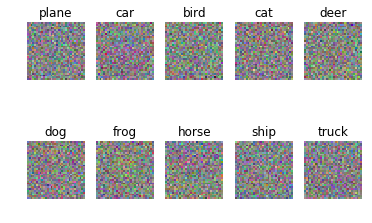

In [8]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])